In [1]:
from root_finding import *

In [2]:
import numpy as np
from pathlib import Path
from tqdm import trange

SAVE_DIR = Path("./saved_trees_trials")
RANKINGS_DIR = SAVE_DIR / "psi_rankings"
RANKINGS_DIR.mkdir(exist_ok=True)

def compute_psi_values_scorer(parents):
    """Compute ψ values for a single parent array."""
    n = len(parents)
    children = [[] for _ in range(n)]
    for u, p in enumerate(parents):
        if p >= 0:
            children[p].append(u)

    subtree = np.ones(n, dtype=int)

    # DFS order
    stack = [0]
    order = []
    while stack:
        u = stack.pop()
        order.append(u)
        for v in children[u]:
            stack.append(v)

    # bottom-up subtree sizes
    for u in reversed(order):
        for v in children[u]:
            subtree[u] += subtree[v]

    psi = np.zeros(n, dtype=int)
    for u in range(n):
        C = [subtree[v] for v in children[u]]
        if u != 0:
            C.append(n - subtree[u])
        psi[u] = max(C) if C else 0
    return psi

# Parameters
K_max = 200
root = 0

# Detect tree sizes automatically from per-trial directories
def detect_n_values(save_dir=SAVE_DIR):
    ns = []
    for f in save_dir.glob("torus_trees_n=*_trials"):
        parts = f.stem.split("n=")
        n = int(parts[1].split("_")[0])
        ns.append(n)
    return sorted(ns)

n_values = detect_n_values()
print("Detected TREE_SIZES:", n_values)

# Main loop: incremental ψ ranking
for n in n_values:
    tree_dir = SAVE_DIR / f"torus_trees_n={n}_trials"
    ranking_dir = RANKINGS_DIR / f"n={n}"
    ranking_dir.mkdir(exist_ok=True)

    # List all trials
    all_trials = sorted(tree_dir.glob("trial_*"))
    existing_files = sorted(ranking_dir.glob("trial_*.npy"))
    existing_count = len(existing_files)
    print(f"\nn={n}, total trials={len(all_trials)}, existing rankings={existing_count}")

    # Start from next trial
    for trial_path in trange(existing_count, len(all_trials), desc=f"n={n}"):
        trial_dir = all_trials[trial_path]
        parents = np.load(trial_dir / "parents.npy")

        psi = compute_psi_values_scorer(parents)
        ranking_nodes = np.argsort(psi)  # nodes sorted by ascending ψ

        np.save(ranking_dir / f"trial_{trial_path:06d}.npy", ranking_nodes)
        del psi, ranking_nodes  # free memory

print("All rankings saved incrementally.")

Detected TREE_SIZES: [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 75000, 100000, 125000]

n=100, total trials=2000, existing rankings=2000


n=100: 0it [00:00, ?it/s]



n=200, total trials=2000, existing rankings=2000


n=200: 0it [00:00, ?it/s]



n=500, total trials=2000, existing rankings=2000


n=500: 0it [00:00, ?it/s]



n=1000, total trials=2000, existing rankings=2000


n=1000: 0it [00:00, ?it/s]


n=2000, total trials=2000, existing rankings=2000

n=2000: 0it [00:00, ?it/s]


n=5000, total trials=2000, existing rankings=2000

n=5000: 0it [00:00, ?it/s]



n=10000, total trials=2000, existing rankings=2000


n=10000: 0it [00:00, ?it/s]



n=20000, total trials=2000, existing rankings=2000


n=20000: 0it [00:00, ?it/s]



n=30000, total trials=2000, existing rankings=2000


n=30000: 0it [00:00, ?it/s]


n=40000, total trials=2000, existing rankings=2000

n=40000: 0it [00:00, ?it/s]



n=50000, total trials=2000, existing rankings=2000


n=50000: 0it [00:00, ?it/s]



n=75000, total trials=2000, existing rankings=2000


n=75000: 0it [00:00, ?it/s]



n=100000, total trials=2000, existing rankings=2000


n=100000: 0it [00:00, ?it/s]



n=125000, total trials=1000, existing rankings=983


n=125000: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]

All rankings saved incrementally.


In [ ]:
import cupy as cp
import numpy as np
from pathlib import Path
import os

K_max = 100
epsilons = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
root = 0

results = {eps: [] for eps in epsilons}


kernel = cp.RawKernel(r'''
extern "C" __global__
void accumulate(int* ranks, int M, int Kmax, int* out) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid >= M) return;

    int r = ranks[tid];
    if (r < 0 || r >= Kmax) return;

    for (int k = r; k < Kmax; k++) {
        atomicAdd(&out[k], 1);
    }
}
''', "accumulate")

for n in n_values:
    print(f"\n=== n={n} ===")

    rank_dir = RANKINGS_DIR / f"n={n}"
    ranking_files = sorted(rank_dir.glob("trial_*.npy"))
    M = len(ranking_files)

    # store ranks on CPU first
    root_ranks_cpu = np.empty(M, dtype=np.int32)

    # ------- load → GPU → find root index --------
    for i, f in enumerate(ranking_files):
        arr = np.load(f)                    # CPU
        arr_gpu = cp.asarray(arr)           # move to GPU
        pos = cp.where(arr_gpu == root)[0]  # GPU search
        root_ranks_cpu[i] = int(pos[0].get())
        del arr_gpu
        cp._default_memory_pool.free_all_blocks()

    # move ranks to GPU
    root_ranks_gpu = cp.asarray(root_ranks_cpu)

    # success counts on GPU
    success_counts_gpu = cp.zeros(K_max, dtype=cp.int32)

    threads = 256
    blocks = (M + threads - 1) // threads

    # launch CUDA kernel
    kernel(
        (blocks,), (threads,),
        (root_ranks_gpu, M, K_max, success_counts_gpu)
    )

    # back to CPU
    success_counts = success_counts_gpu.get()
    cp._default_memory_pool.free_all_blocks()

    p_nK = success_counts / M

    # find K_n(eps)
    for eps in epsilons:
        idx = np.argmax(p_nK >= 1 - eps)
        if p_nK[idx] >= 1 - eps:
            results[eps].append(idx + 1)
        else:
            results[eps].append(np.nan)

print("DONE (GPU)!")



=== n=100 ===

=== n=200 ===

=== n=500 ===

=== n=1000 ===

=== n=2000 ===

=== n=5000 ===

=== n=10000 ===

=== n=20000 ===

=== n=30000 ===

=== n=40000 ===

=== n=50000 ===

=== n=75000 ===

=== n=100000 ===

=== n=125000 ===
DONE (GPU)!


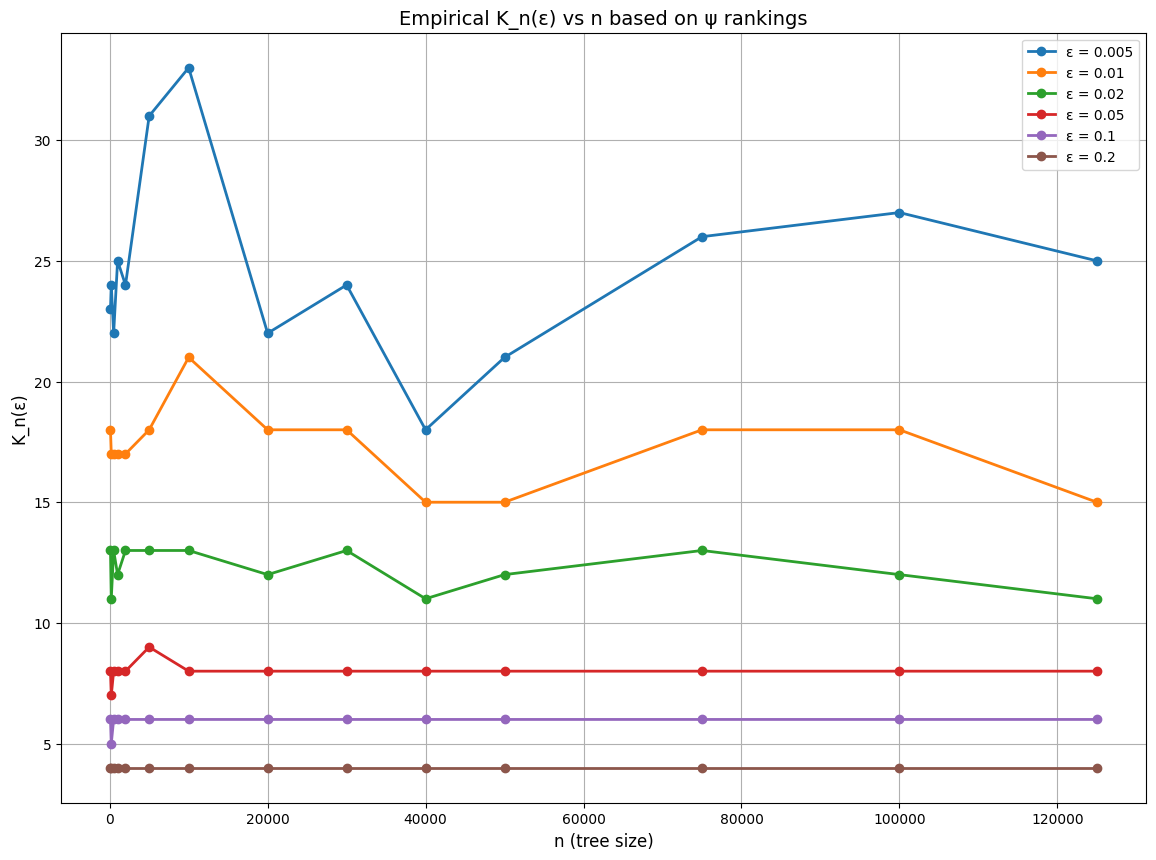

In [12]:
# Plot
scale = 1

plt.rcParams.update({
    "font.size": 10 * scale,        # base font
    "axes.labelsize": 12 * scale,   # axis labels
    "axes.titlesize": 14 * scale,   # title
    "xtick.labelsize": 10 * scale,
    "ytick.labelsize": 10 * scale,
    "legend.fontsize": 10 * scale,
    "lines.markersize": 6 * scale,  # marker size
    "lines.linewidth": 2 * scale,   # thicker lines
})

plt.figure(figsize=(14,10))
for eps in epsilons[1:]:
    plt.plot(n_values, results[eps], marker='o', label=f"ε = {eps}")

plt.xlabel("n (tree size)")
plt.ylabel("K_n(ε)")
plt.title("Empirical K_n(ε) vs n based on ψ rankings")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import numpy as np
from pathlib import Path
from tqdm import trange

def save_trial_statistic_array(
    tree_base_dir: Path,
    stat_base_dir: Path,
    stat_name: str,
    stat_func,
    dtype=np.float32
):
    """
    Compute a statistic for each trial and save as a single .npy array per tree size.
    Existing arrays are extended if new trials are added.
    """
    stat_dir_base = Path(stat_base_dir) / stat_name
    stat_dir_base.mkdir(parents=True, exist_ok=True)

    # Detect all tree sizes automatically
    n_values = sorted([int(f.stem.split("n=")[1].split("_")[0])
                       for f in tree_base_dir.glob("torus_trees_n=*_trials")])
    print("Detected tree sizes:", n_values)

    for n in n_values:
        tree_dir = tree_base_dir / f"torus_trees_n={n}_trials"
        stat_file = stat_dir_base / f"n={n}.npy"

        all_trials = sorted(tree_dir.glob("trial_*"))
        M = len(all_trials)

        # Load existing stats if present
        if stat_file.exists():
            stats = np.load(stat_file)
            start_idx = len(stats)
            stats = stats.tolist()  # convert to list for easy appending
        else:
            stats = []
            start_idx = 0

        print(f"\nn={n}, total trials={M}, existing stats={start_idx}")

        for trial_idx in trange(start_idx, M, desc=f"n={n}"):
            trial_dir = all_trials[trial_idx]
            parents = np.load(trial_dir / "parents.npy")
            points = np.load(trial_dir / "points.npy")

            # Compute statistic
            stat_value = stat_func(parents, points)
            stats.append(stat_value)

            del parents, points, stat_value  # free memory

        # Save the updated array
        np.save(stat_file, np.array(stats, dtype=dtype))

    print(f"All '{stat_name}' statistics saved/extended successfully.")




In [ ]:


SAVE_DIR = Path("./saved_trees_trials")
STAT_DIR = SAVE_DIR / "statistics"
STAT_DIR.mkdir(exist_ok=True)

def largest_root_child_fraction_stat(parents, points):
    return largest_root_child_fraction(parents)

# Run incremental saving with single-array storage
save_trial_statistic_array(
    tree_base_dir=SAVE_DIR,
    stat_base_dir=STAT_DIR,
    stat_name="largest_root_child_fraction",
    stat_func=largest_root_child_fraction_stat
)

Detected tree sizes: [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 75000, 100000, 125000]

n=100, total trials=2000, existing stats=2000


n=100: 0it [00:00, ?it/s]



n=200, total trials=2000, existing stats=2000


n=200: 0it [00:00, ?it/s]



n=500, total trials=2000, existing stats=2000


n=500: 0it [00:00, ?it/s]



n=1000, total trials=2000, existing stats=2000


n=1000: 0it [00:00, ?it/s]



n=2000, total trials=2000, existing stats=2000


n=2000: 0it [00:00, ?it/s]



n=5000, total trials=2000, existing stats=2000


n=5000: 0it [00:00, ?it/s]



n=10000, total trials=2000, existing stats=2000


n=10000: 0it [00:00, ?it/s]



n=20000, total trials=2000, existing stats=2000


n=20000: 0it [00:00, ?it/s]



n=30000, total trials=2000, existing stats=2000


n=30000: 0it [00:00, ?it/s]



n=40000, total trials=2000, existing stats=2000


n=40000: 0it [00:00, ?it/s]



n=50000, total trials=2000, existing stats=2000


n=50000: 0it [00:00, ?it/s]



n=75000, total trials=2000, existing stats=2000


n=75000: 0it [00:00, ?it/s]



n=100000, total trials=2000, existing stats=2000


n=100000: 0it [00:00, ?it/s]



n=125000, total trials=1000, existing stats=1000


n=125000: 0it [00:00, ?it/s]

All 'largest_root_child_fraction' statistics saved/extended successfully.



Processing N = 100
Best trial for N=100: trial 1336, fraction = 0.990000
Voronoi fractions already exist for best trial 1336, skipping computation.

Processing N = 200
Best trial for N=200: trial 1066, fraction = 0.995000
Voronoi fractions already exist for best trial 1066, skipping computation.

Processing N = 500
Best trial for N=500: trial 518, fraction = 0.996000
Voronoi fractions already exist for best trial 518, skipping computation.

Processing N = 1000
Best trial for N=1000: trial 598, fraction = 0.989000
Voronoi fractions already exist for best trial 598, skipping computation.

Processing N = 2000
Best trial for N=2000: trial 653, fraction = 0.989000
Voronoi fractions already exist for best trial 653, skipping computation.

Processing N = 5000
Best trial for N=5000: trial 1872, fraction = 0.990600
Voronoi fractions already exist for best trial 1872, skipping computation.

Processing N = 10000
Best trial for N=10000: trial 521, fraction = 0.989800
Voronoi fractions already exi

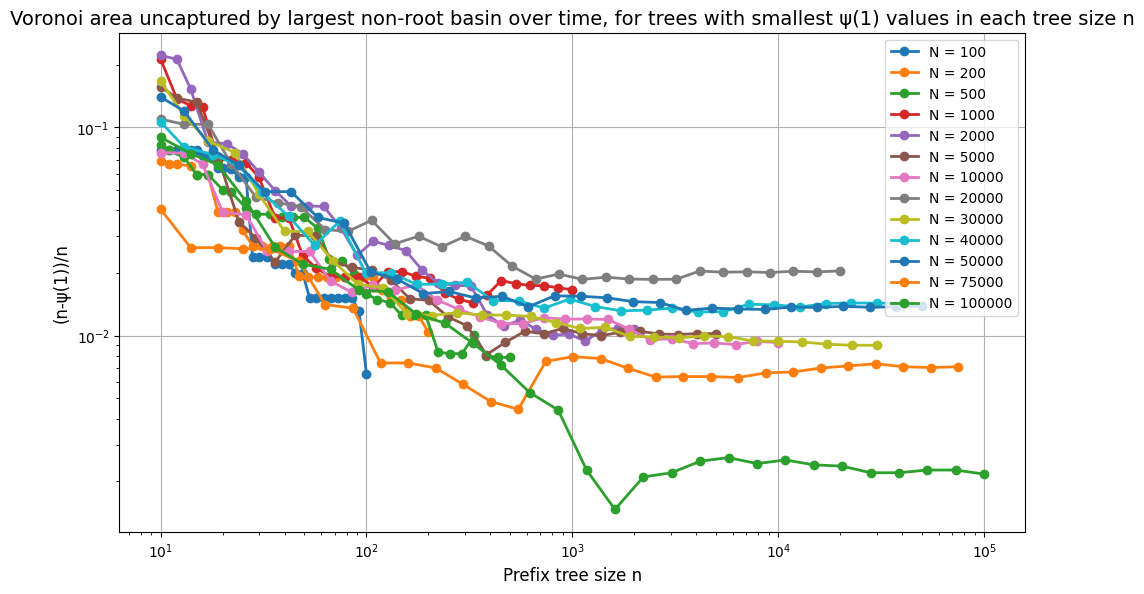

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

SAVE_DIR = Path("./saved_trees_trials")
STAT_DIR = SAVE_DIR / "statistics" / "largest_root_child_fraction"


TREE_SIZES = [100, 200, 500, 1000, 2000, 5000,10000,20000,30000,40000,50000,75000,100000]#,125000]

# Monte Carlo parameters
mc_samples_per_point = 10
mc_samples=30000
mc_batch = 2000
rng_global = np.random.default_rng(12345)

# Storage for final overlay plot
curves = {}


for N in TREE_SIZES:
    # mc_samples=N*mc_samples_per_point
    print("\n" + "="*75)
    print(f"Processing N = {N}")
    print("="*75)

    # Load precomputed largest_root_child_fraction values
    stat_file = STAT_DIR / f"n={N}.npy"
    if not stat_file.exists():
        raise FileNotFoundError(f"Precomputed largest_root_child_fraction file not found: {stat_file}")
    
    fractions = np.load(stat_file)
    best_idx = int(np.argmax(fractions))
    print(f"Best trial for N={N}: trial {best_idx}, fraction = {fractions[best_idx]:.6f}")

    # Directory to store Voronoi fractions for this best trial
    vor_dir = SAVE_DIR / "voronoi_fractions" / f"n={N}" / f"best_trial_{best_idx}"

    # Skip computation if folder already exists
    if vor_dir.exists():
        print(f"Voronoi fractions already exist for best trial {best_idx}, skipping computation.")
        # Load existing areas
        prefix_files = sorted(vor_dir.glob("prefix_*.npy"))
        prefix_sizes = [int(f.stem.split("_")[1]) for f in prefix_files]
        areas_over_time = [np.load(f) for f in prefix_files]
        curves[N] = (np.array(prefix_sizes), np.array(areas_over_time))
        continue

    # Load the best trial's parents and positions
    tree_dir = SAVE_DIR / f"torus_trees_n={N}_trials"
    trial_dir = tree_dir / f"trial_{best_idx:06d}"
    best_parents = np.load(trial_dir / "parents.npy")
    best_positions = np.load(trial_dir / "points.npy")

    # Step 2: Prefix sizes
    import numpy as np

    num_points = 30  # how many prefix sizes you want

    # Log-spaced floating points, then round to integers and remove duplicates
    prefix_sizes = np.unique(np.round(np.logspace(np.log10(10), np.log10(N), num=num_points)).astype(int))

    vor_dir.mkdir(parents=True, exist_ok=True)
    areas_over_time = []

    for m in tqdm(prefix_sizes, desc=f"Voronoi prefixes N={N}"):
        parents_sub = best_parents[:m]
        positions_sub = best_positions[:m]
        mask_sub = largest_root_child_indices(parents_sub)

        area = estimate_basin_area_gpu(
            positions_sub,
            mask_sub,
            samples=mc_samples,
            batch_size=mc_batch,
            rng=rng_global
        )
        np.save(vor_dir / f"prefix_{m}.npy", area)
        areas_over_time.append(area)

    curves[N] = (prefix_sizes, np.array(areas_over_time))

# Final overlay plot
plt.figure(figsize=(10, 6))
for N in TREE_SIZES:
    prefix_sizes, areas_over_time = curves[N]
    # Get sorted indices
    sorted_idx = np.argsort(prefix_sizes)

    # Reorder both arrays
    prefix_sizes = prefix_sizes[sorted_idx]
    areas_over_time = 1-areas_over_time[sorted_idx]
    plt.plot(prefix_sizes, areas_over_time,
             marker='o', linewidth=2, label=f"N = {N}")

plt.xlabel("Prefix tree size n")
plt.ylabel("(n-ψ(1))/n")
plt.title("Voronoi area uncaptured by largest non-root basin over time, for trees with smallest ψ(1) values in each tree size n")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.ylim(0.0001,.1)
plt.yscale("log")
plt.xscale("log")
plt.show()



Processing N = 100
Top 3 trials for N=100: [1336   67 1188] with fractions [0.99 0.98 0.98]

--- N=100, rank=1, trial=1336, fraction=0.990000 ---
  Found existing Voronoi prefix data. Loading…

--- N=100, rank=2, trial=67, fraction=0.980000 ---
  Found existing Voronoi prefix data. Loading…

--- N=100, rank=3, trial=1188, fraction=0.980000 ---
  Found existing Voronoi prefix data. Loading…

Processing N = 200
Top 3 trials for N=200: [1066 1640 1083] with fractions [0.995 0.985 0.98 ]

--- N=200, rank=1, trial=1066, fraction=0.995000 ---
  Found existing Voronoi prefix data. Loading…

--- N=200, rank=2, trial=1640, fraction=0.985000 ---
  Found existing Voronoi prefix data. Loading…

--- N=200, rank=3, trial=1083, fraction=0.980000 ---
  Found existing Voronoi prefix data. Loading…

Processing N = 500
Top 3 trials for N=500: [ 518 1440   16] with fractions [0.996 0.99  0.98 ]

--- N=500, rank=1, trial=518, fraction=0.996000 ---
  Found existing Voronoi prefix data. Loading…

--- N=500,

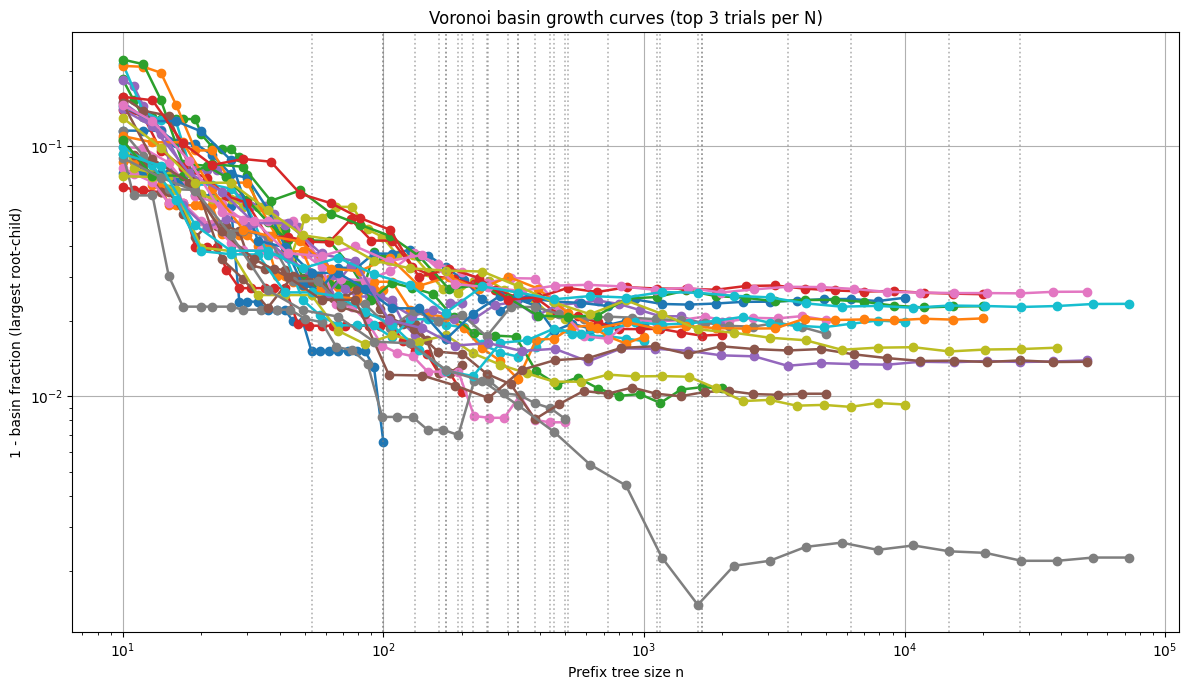

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# Config
SAVE_DIR = Path("./saved_trees_trials")
STAT_DIR = SAVE_DIR / "statistics" / "largest_root_child_fraction"

TREE_SIZES = [100, 200, 500, 1000, 2000, 5000,10000,20000,50000,100000]

mc_samples=30000
mc_batch = 2000
rng_global = np.random.default_rng(12345)

# curves[(N, rank)] = (prefix_sizes, areas)
curves = {}

# Main loop over tree sizes
for N in TREE_SIZES:
    print("\n" + "="*75)
    print(f"Processing N = {N}")
    print("="*75)

    stat_file = STAT_DIR / f"n={N}.npy"
    if not stat_file.exists():
        raise FileNotFoundError(f"Missing: {stat_file}")

    fractions = np.load(stat_file)

    # ---- ★★ GET TOP 3 BEST TRIALS ★★ ----
    best3_idx = np.argsort(fractions)[-3:][::-1]   # descending order
    print(f"Top 3 trials for N={N}: {best3_idx} with fractions {fractions[best3_idx]}")

    for rank, trial_idx in enumerate(best3_idx, start=1):
        print(f"\n--- N={N}, rank={rank}, trial={trial_idx}, fraction={fractions[trial_idx]:.6f} ---")

        vor_dir = SAVE_DIR / "voronoi_fractions" / f"n={N}" / f"trial_{trial_idx}"

        # If data exists, load it
        if vor_dir.exists():
            print("  Found existing Voronoi prefix data. Loading…")
            prefix_files = sorted(vor_dir.glob("prefix_*.npy"))
            prefix_sizes = [int(f.stem.split("_")[1]) for f in prefix_files]
            areas_over_time = [np.load(f) for f in prefix_files]

            curves[(N, rank)] = (np.array(prefix_sizes),
                                 np.array(areas_over_time))
            continue

        # Otherwise compute it
        print("  Computing prefix Voronoi fractions…")

        tree_dir = SAVE_DIR / f"torus_trees_n={N}_trials"
        trial_dir = tree_dir / f"trial_{trial_idx:06d}"

        parents = np.load(trial_dir / "parents.npy")
        positions = np.load(trial_dir / "points.npy")

        num_points = 30
        prefix_sizes = np.unique(
            np.round(np.logspace(np.log10(10), np.log10(N), num=num_points)).astype(int)
        )

        vor_dir.mkdir(parents=True, exist_ok=True)
        areas_over_time = []

        for m in tqdm(prefix_sizes, desc=f"N={N}, trial={trial_idx}"):
            parents_sub = parents[:m]
            positions_sub = positions[:m]
            mask_sub = largest_root_child_indices(parents_sub)

            area = estimate_basin_area_gpu(
                positions_sub,
                mask_sub,
                samples=mc_samples,
                batch_size=mc_batch,
                rng=rng_global
            )
            np.save(vor_dir / f"prefix_{m}.npy", area)
            areas_over_time.append(area)

        curves[(N, rank)] = (prefix_sizes, np.array(areas_over_time))

# Final composite plot
plt.figure(figsize=(12, 7))

for N in TREE_SIZES:
    for rank in [1,2,3]:
        if (N, rank) not in curves:
            continue

        prefix_sizes, areas = curves[(N, rank)]

        # sort by prefix size
        idx = np.argsort(prefix_sizes)
        prefix_sizes = prefix_sizes[idx]
        areas = 1 - areas[idx]
        x_min = prefix_sizes[np.argmin(areas)]
        plt.axvline(x_min, linestyle='dotted', linewidth=1.2, color='gray', alpha=0.6, label="mininum values") 
        plt.plot(prefix_sizes, areas,
                 marker='o', linewidth=1.8,
                 label=f"N={N}  (#{rank})")

plt.xlabel("Prefix tree size n")
plt.ylabel("1 - basin fraction (largest root-child)")
plt.title("Voronoi basin growth curves (top 3 trials per N)")
plt.grid(True)
# plt.legend(ncol=2)
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.show()



================== SUMMARY ==================
n=100, mean=0.587840, std=0.165855, max=0.990000
n=1000, mean=0.577772, std=0.165835, max=0.989000
n=10000, mean=0.582342, std=0.164779, max=0.989800
n=100000, mean=0.584774, std=0.160458, max=0.998020
n=125000, mean=0.584164, std=0.162173, max=0.986608
n=200, mean=0.570713, std=0.160075, max=0.995000
n=2000, mean=0.584626, std=0.163462, max=0.989000
n=20000, mean=0.581170, std=0.163349, max=0.981200
n=30000, mean=0.582454, std=0.160886, max=0.990500
n=40000, mean=0.578529, std=0.158265, max=0.985375
n=500, mean=0.576816, std=0.163743, max=0.996000
n=5000, mean=0.580723, std=0.165408, max=0.990600
n=50000, mean=0.582495, std=0.164381, max=0.986020
n=75000, mean=0.588626, std=0.164989, max=0.993387


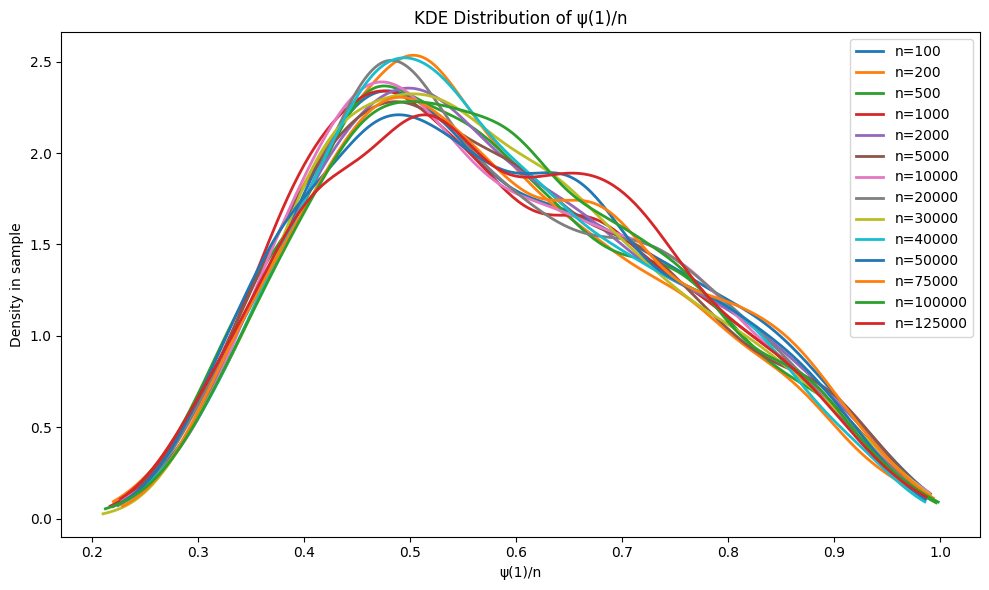

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from pathlib import Path

# Paths
STAT_DIR = Path("saved_trees_trials/statistics/largest_root_child_fraction")

# Automatically detect available n values
tree_files = sorted(STAT_DIR.glob("n=*.npy"))
tree_sizes = [int(f.stem.split("=")[1]) for f in tree_files]

# Load results from saved files
results = {}

print("\n================== SUMMARY ==================")
for n in tree_sizes:
    path = STAT_DIR / f"n={n}.npy"
    if not path.exists():
        print(f"(Skipping n={n}; file not found)")
        continue

    arr = np.load(path)
    results[n] = arr

    print(f"n={n}, mean={arr.mean():.6f}, std={arr.std():.6f}, max={arr.max():.6f}")

# KDE Plotting
def plot_percentage_distributions(all_results):
    """
    all_results[n] = array of fraction values from trials.
    Plots KDE curves for all n on one figure.
    """
    plt.figure(figsize=(10, 6))

    for n, vals in sorted(all_results.items()):
        if len(vals) < 2:
            continue  # KDE cannot run on <2 values

        vals = np.asarray(vals)

        kde = gaussian_kde(vals)
        xs = np.linspace(vals.min(), vals.max(), 300)
        ys = kde(xs)

        plt.plot(xs, ys, linewidth=2, label=f"n={n}")

    plt.title("KDE Distribution of ψ(1)/n")
    plt.xlabel("ψ(1)/n")
    plt.ylabel("Density in sample")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_percentage_distributions(results)


In [ ]:
import os
import numpy as np
from pathlib import Path


base_dir = Path("./saved_trees_trials")        # main directory
n_existing = 100000
trial_index = 159
M = 95                   # number of continuations
n_total = 20000  
keep_n=1200        # total size after continuation

trial_dir = os.path.join(base_dir, f"torus_trees_n={n_existing}_trials", f"trial_{trial_index:06d}")
parents_path = os.path.join(trial_dir, "parents.npy")
points_path = os.path.join(trial_dir, "points.npy")

parents_existing = np.load(parents_path)
positions_existing = np.load(points_path)

continuations_dir = os.path.join(base_dir, "continuations", f"n={n_existing}", f"trial_{trial_index:06d}")
os.makedirs(continuations_dir, exist_ok=True)


for m in range(M):
    seed = np.random.randint(0, 1_000_000)
    parents_new, positions_new = continue_tree(
        parents_existing, positions_existing, n_new=n_total, seed=seed, keep_n=keep_n
    )
    
    # Save each continuation
    np.save(os.path.join(continuations_dir, f"parents_cont_{m}_from_{keep_n}_to{n_total}.npy"), parents_new)
    np.save(os.path.join(continuations_dir, f"points_cont_{m}_from_{keep_n}_to{n_total}.npy"), positions_new)
    
    print(f"Continuation {m+1}/{M} saved to {continuations_dir}")

print(f"All {M} continuations for trial {trial_index} saved successfully.")


Continuation 1/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 2/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 3/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 4/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 5/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 6/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 7/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 8/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 9/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 10/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 11/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 12/95 saved to saved_trees_trials\continuations\n=100000\trial_000159
Continuation 

Continuation 4 prefixes: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


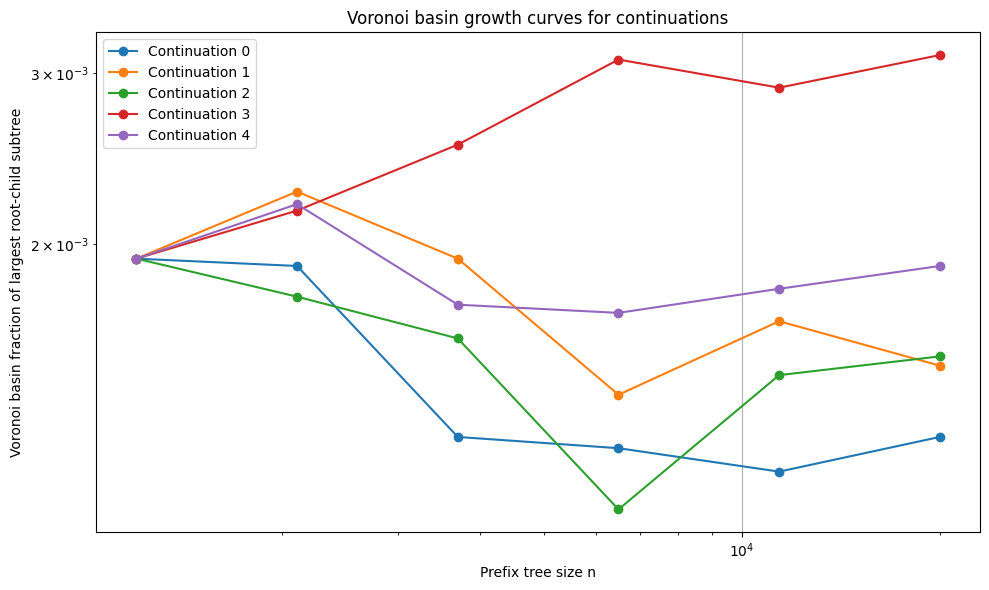

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm


base_dir = Path("./saved_trees_trials")
continuations_dir = base_dir / "continuations" / "n=100000" / "trial_000159"

# Monte Carlo parameters
mc_samples = 30000
mc_batch = 2000
rng_global = np.random.default_rng(12345)

start=1200
# Prefix sizes for which to compute Voronoi fractions


curves = {}
continuation_files = sorted(continuations_dir.glob("parents_cont_*.npy"))

for idx, parent_file in enumerate(continuation_files[:5]):
    points_file = continuations_dir / parent_file.name.replace("parents", "points")
    parents = np.load(parent_file)
    points = np.load(points_file)
    
    num_points = 6
    n_total=len(parents)
    prefix_sizes = np.unique(np.round(np.logspace(np.log10(start), np.log10(n_total), num=num_points)).astype(int))

    areas_over_time = []
    for m in tqdm(prefix_sizes, desc=f"Continuation {idx} prefixes"):
        parents_sub = parents[:m]
        positions_sub = points[:m]
        mask_sub = largest_root_child_indices(parents_sub)
        area = estimate_basin_area_gpu(
            positions_sub, mask_sub, samples=mc_samples, batch_size=mc_batch, rng=rng_global
        )
        areas_over_time.append(area)
    
    curves[idx] = (prefix_sizes, np.array(areas_over_time))


plt.figure(figsize=(10,6))
for idx, (prefix_sizes, areas_over_time) in curves.items():
    plt.plot(prefix_sizes, 1 - areas_over_time, marker='o', label=f"Continuation {idx}")

plt.xlabel("Prefix tree size n")
plt.ylabel("Voronoi basin fraction of largest root-child subtree")
plt.title("Voronoi basin growth curves for continuations")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Processing continuations:   0%|          | 0/95 [00:00<?, ?it/s]

Processing continuations: 100%|██████████| 95/95 [00:02<00:00, 31.91it/s]


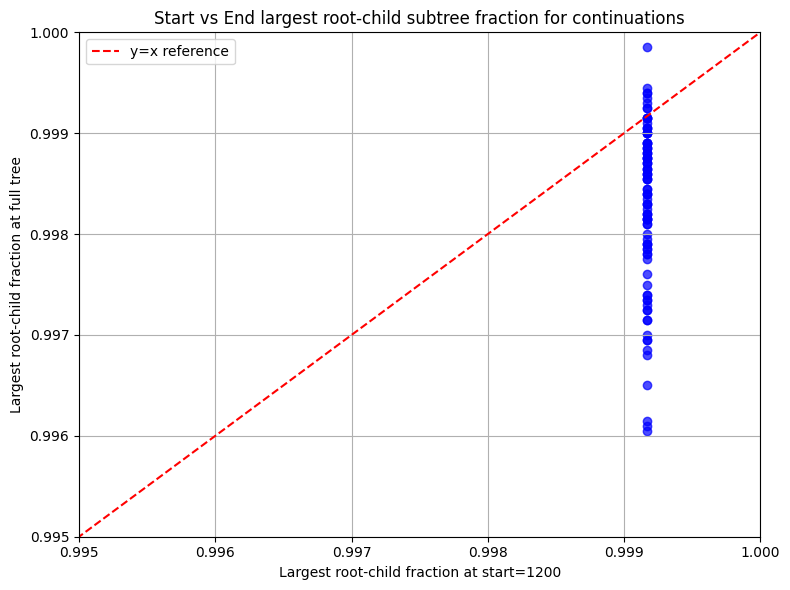

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# Config
base_dir = Path("./saved_trees_trials")
continuations_dir = base_dir / "continuations" / "n=100000" / "trial_000159"

start = 1200  # starting prefix to compute fraction

continuation_files = sorted(continuations_dir.glob("parents_cont_*.npy"))
fractions_start = []
fractions_end = []

for parent_file in tqdm(continuation_files, desc="Processing continuations"):
    parents = np.load(parent_file)
    
    # Fraction at starting value
    if start > len(parents):
        raise ValueError(f"start={start} exceeds tree size={len(parents)}")
    frac_start = largest_root_child_fraction(parents[:start])
    fractions_start.append(frac_start)
    
    # Fraction at full tree
    frac_end = largest_root_child_fraction(parents)
    fractions_end.append(frac_end)

fractions_start = np.array(fractions_start)
fractions_end = np.array(fractions_end)

# Plot start vs end
plt.figure(figsize=(8,6))
plt.scatter(fractions_start, fractions_end, color='blue', alpha=0.7)
plt.plot([0,1], [0,1], 'r--', label="y=x reference")
plt.xlabel(f"Largest root-child fraction at start={start}")
plt.ylabel("Largest root-child fraction at full tree")
plt.title("Start vs End largest root-child subtree fraction for continuations")
plt.grid(True)
plt.legend()
plt.xlim(.995,1)
plt.ylim(.995,1)
plt.tight_layout()
plt.show()


[ 0.35745379 -0.35205579] [ 0.35745379 -0.35205579]
[-0.21852148 -0.79471977] [-0.21852148  0.20528023]
[-0.09793503  0.71018161] [-0.09793503 -0.28981839]
[-0.13087893  0.1094141 ] [-0.13087893  0.1094141 ]
[-0.03749912  0.10373372] [-0.03749912  0.10373372]
[ 0.81185815 -0.75757073] [-0.18814185  0.24242927]
[0.02580632 0.02740999] [0.02580632 0.02740999]
[-0.29687274 -0.18331617] [-0.29687274 -0.18331617]
[ 0.12770277 -0.2335273 ] [ 0.12770277 -0.2335273 ]
[-0.22058976 -0.07284525] [-0.22058976 -0.07284525]
[-0.13980037  0.07513273] [-0.13980037  0.07513273]
[-0.14504501  0.07710338] [-0.14504501  0.07710338]
[-0.10456847 -0.01052201] [-0.10456847 -0.01052201]
[-0.01943833 -0.09304345] [-0.01943833 -0.09304345]
[-0.00430804  0.03103025] [-0.00430804  0.03103025]
[ 0.0444671  -0.02102429] [ 0.0444671  -0.02102429]
[ 0.90754841 -0.05777878] [-0.09245159 -0.05777878]
[ 0.1227888  -0.08573239] [ 0.1227888  -0.08573239]
[-0.0477609  -0.15850601] [-0.0477609  -0.15850601]
[-0.07763555 -0.

C:\Users\User\AppData\Local\Temp\ipykernel_26720\3989066834.py:196: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


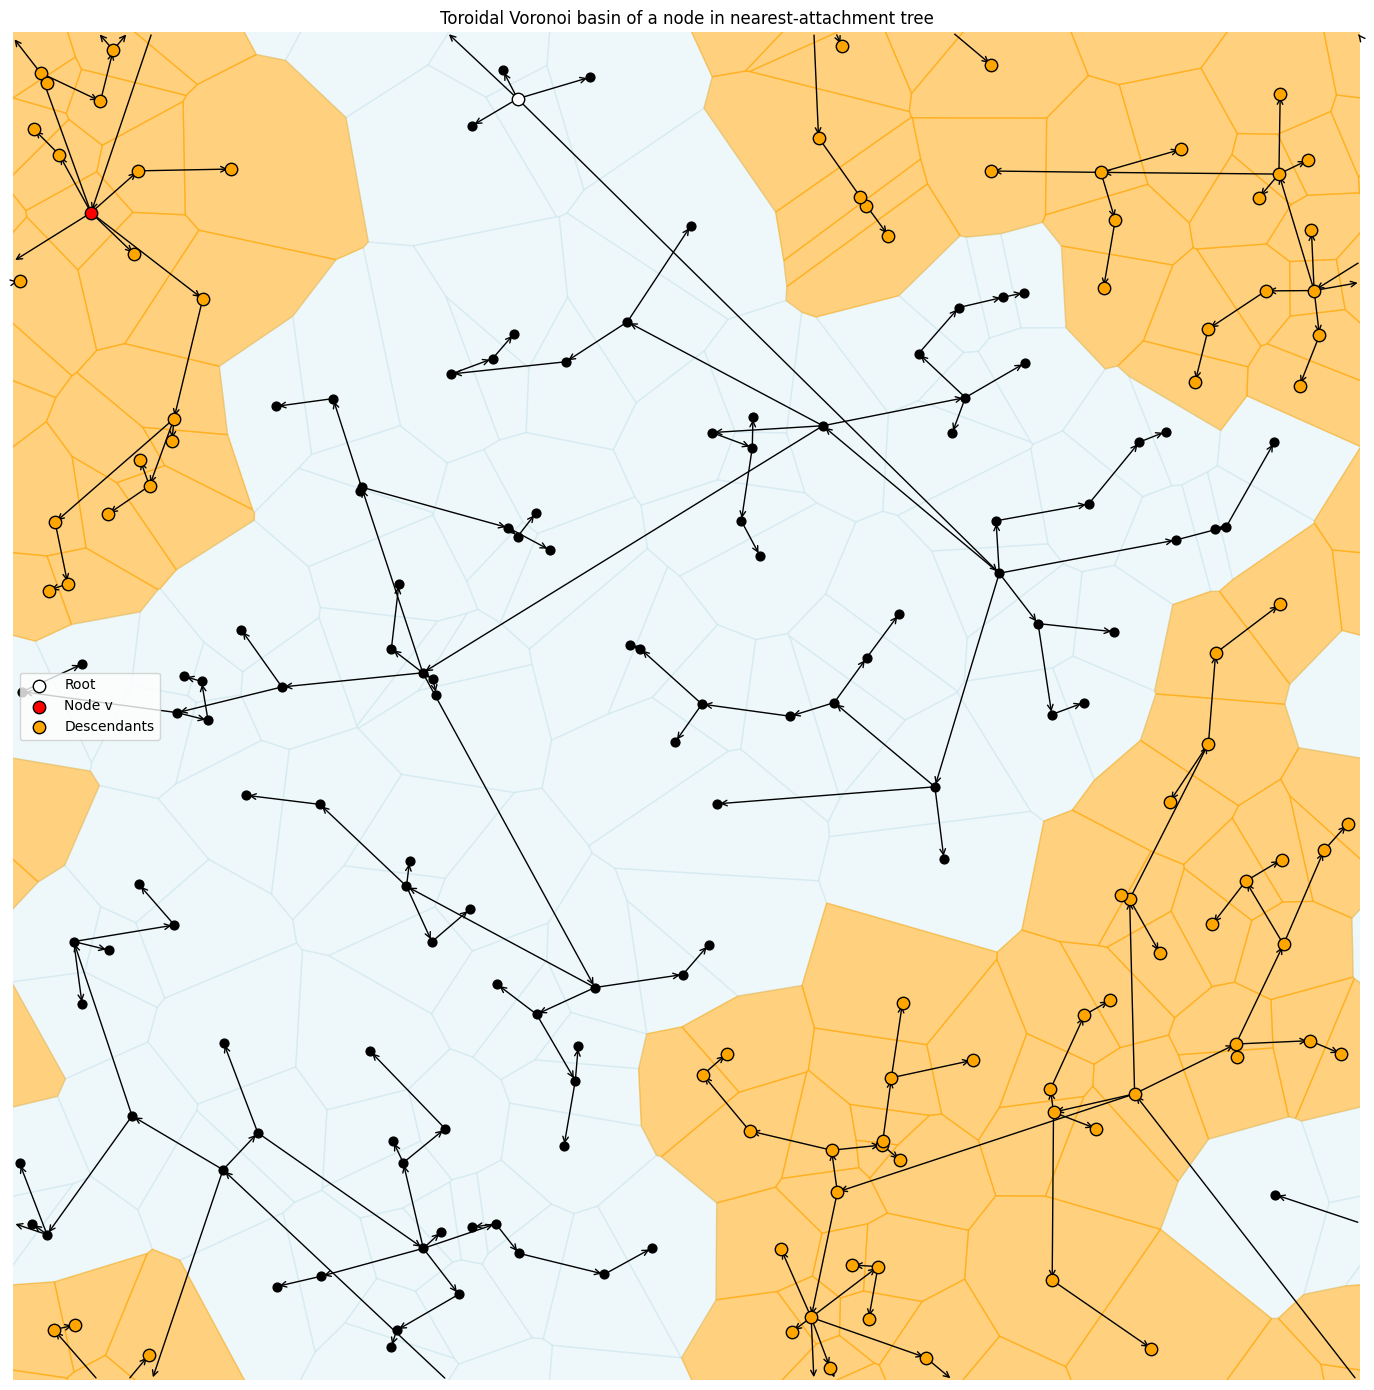

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

# Generate small nearest-attachment tree
n_nodes = 200
d = 2
seed = 42

parents, points = nearest_attachment_tree_blockwise_gpu(n=n_nodes, d=d, seed=seed)

highlight_node = 3  # node whose basin to highlight

# Find descendants
def get_descendants(parents, node):
    descendants = []
    stack = [node]
    while stack:
        u = stack.pop()
        for i, p in enumerate(parents):
            if p == u:
                descendants.append(i)
                stack.append(i)
    return descendants

descendants = get_descendants(parents, highlight_node)
basin_nodes = [highlight_node] + descendants

# Create 3x3 tiled points for toroidal Voronoi
shifts = [-1, 0, 1]
tiled_points = []
tiled_indices = []
for dx in shifts:
    for dy in shifts:
        shift_vec = np.array([dx, dy])
        for i, p in enumerate(points):
            tiled_points.append(p + shift_vec)
            tiled_indices.append(i)
tiled_points = np.array(tiled_points)
tiled_indices = np.array(tiled_indices)

# Voronoi diagram on tiled points
vor = Voronoi(tiled_points)

# Plot
fig, ax = plt.subplots(figsize=(14,14))

# Color Voronoi cells
for i, idx in enumerate(tiled_indices):
    region_index = vor.point_region[i]
    region = vor.regions[region_index]
    if not -1 in region and region != []:
        polygon = np.array([vor.vertices[j] for j in region])
        if idx in basin_nodes:
            ax.fill(*zip(*polygon), color='orange', alpha=0.5)
        else:
            ax.fill(*zip(*polygon), color='lightblue', alpha=0.2)

# Draw arrows along shortest parent distance in tiled copies
def torus_vector(start, end):
    """Compute torus-wrapped vector from start to end in [0,1]^2"""
    vec = end - start
    #vec -= np.round(vec)  # wrap to [-0.5,0.5]
    return vec



import numpy as np
def first_boundary_hit(parent, vec):
    # boundary[i] = 1 if vec[i] < 0, else 0
    boundary = (vec > 0).astype(float)

    # compute intersection times
    with np.errstate(divide='ignore', invalid='ignore'):
        t = (boundary - parent) / vec

    #print(t,"t")

    # discard non-positive or invalid intersections
    t[(t <= 0) | ~np.isfinite(t)] = np.inf

    # earliest intersection
    t_hit = np.min(t)

    # endpoint of clipped ray
    end_point = parent + t_hit * vec
    #print(end_point,"end")
    return t_hit, end_point

def opposite_boundary_point(hit):
    x, y = hit

    # Flip x only if it's on boundary
    if np.isclose(x, 0.0):
        ox = 1.0
    elif np.isclose(x, 1.0):
        ox = 0.0
    else:
        ox = x

    # Flip y only if it's on boundary
    if np.isclose(y, 0.0):
        oy = 1.0
    elif np.isclose(y, 1.0):
        oy = 0.0
    else:
        oy = y

    return np.array([ox, oy])

def draw_torus_arrow(ax, start, end):
    start = np.array(start, float)
    end   = np.array(end,   float)

    # Minimal displacement on torus
    d = end - start
    d[d >  0.5] -= 1
    d[d < -0.5] += 1
    vec=end-start

    print(vec, d)

    if abs(vec[0])>.5 or abs(vec[1])>.5:
        #draw first segment
        _,hit=first_boundary_hit(start,d)

        ax.annotate("",
                xy=hit,
                xytext=start,
                arrowprops=dict(arrowstyle="->", color='black', lw=1))
        _,hit=first_boundary_hit(end,-d)

        ax.annotate("",
                xy=end,
                xytext=hit,
                arrowprops=dict(arrowstyle="->", color='black', lw=1))
    if abs(vec[0])>.5 and abs(vec[1])>.5:
        _,hit1=first_boundary_hit(start,d)
        _,hit2=first_boundary_hit(end,-d)
        hit1=opposite_boundary_point(hit1)
        hit2=opposite_boundary_point(hit2)
        ax.annotate("",
                xy=hit2,
                xytext=hit1,
                arrowprops=dict(arrowstyle="->", color='black', lw=1))
    if abs(vec[0])<.5 and abs(vec[1])<.5:
        ax.annotate("",
                xy=end,
                xytext=start,
                arrowprops=dict(arrowstyle="->", color='black', lw=1))

    # Wrapped coordinates only for drawing
   


for i, p in enumerate(parents):
    if p >= 0:
        draw_torus_arrow(ax, points[p], points[i])



ax.scatter(points[0,0], points[0,1], c='white', edgecolors='black', s=80, zorder=4, label="Root")
ax.scatter(points[highlight_node,0], points[highlight_node,1], c='red', edgecolors='black',zorder=4, s=80, label='Node v')
ax.scatter(points[descendants,0], points[descendants,1], c='orange', edgecolors='black',zorder=4, s=80, label='Descendants')
ax.scatter(points[:,0], points[:,1], c='black', s=40, zorder=3)


# Zoom in on central tile
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title("Toroidal Voronoi basin of a node in nearest-attachment tree")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from pathlib import Path
from tqdm import trange

def save_trial_statistic_array_limited(
    tree_base_dir: Path,
    stat_base_dir: Path,
    stat_name: str,
    stat_func,
    dtype=np.float32,
    num_trees=100
):
    """
    Compute a statistic for each trial and save as a single .npy array per tree size.
    Existing arrays are extended if new trials are added.
    """
    stat_dir_base = Path(stat_base_dir) / stat_name
    stat_dir_base.mkdir(parents=True, exist_ok=True)

    # Detect all tree sizes automatically
    n_values = sorted([int(f.stem.split("n=")[1].split("_")[0])
                       for f in tree_base_dir.glob("torus_trees_n=*_trials")])
    print("Detected tree sizes:", n_values)

    for n in n_values:
        tree_dir = tree_base_dir / f"torus_trees_n={n}_trials"
        stat_file = stat_dir_base / f"n={n}.npy"

        all_trials = sorted(tree_dir.glob("trial_*"))
        M = len(all_trials)

        # Load existing stats if present
        if stat_file.exists():
            stats = np.load(stat_file)
            start_idx = len(stats)
            stats = stats.tolist()  # convert to list for easy appending
        else:
            stats = []
            start_idx = 0

        print(f"\nn={n}, total trials={M}, existing stats={start_idx}")

        for trial_idx in trange(start_idx, min(M,num_trees), desc=f"n={n}"):
            trial_dir = all_trials[trial_idx]
            parents = np.load(trial_dir / "parents.npy")
            points = np.load(trial_dir / "points.npy")

            # Compute statistic
            stat_value = stat_func(parents, points)
            stats.append(stat_value)

            del parents, points, stat_value  # free memory

        # Save the updated array
        np.save(stat_file, np.array(stats, dtype=dtype))

    print(f"All '{stat_name}' statistics saved/extended successfully.")



def contraction_random_nodes(parents, K=500, rng=None):
    """
    Sample K random nodes and compute the contraction ratio:
        R(v) = (largest child subtree of v) / (subtree size of v)
    Returns: array of length K
    """
    n = len(parents)
    if rng is None:
        rng = np.random.default_rng()

    # choose nodes except the root (0)
    nodes = rng.integers(0, n, size=K)

    # Compute subtree sizes (linear time)
    children = [[] for _ in range(n)]
    for child, p in enumerate(parents):
        if p >= 0:
            children[p].append(child)

    subtree = np.ones(n, dtype=np.int32)
    for u in reversed(range(n)):
        for c in children[u]:
            subtree[u] += subtree[c]

    # compute contraction ratios
    ratios = []
    for v in nodes:
        t = subtree[v]
        if t <= 1:
            ratios.append(0.0)
            continue
        child_sizes = [subtree[c] for c in children[v]]
        if len(child_sizes) == 0:
            ratios.append(0.0)
            continue
        ratios.append(max(child_sizes) / t)

    return np.array(ratios, dtype=np.float32)


SAVE_DIR = Path("./saved_trees_trials")
STAT_DIR = SAVE_DIR / "statistics"
STAT_DIR.mkdir(exist_ok=True)

def contraction_random_nodes_stat(parents, points):
    return contraction_random_nodes(parents)

# Run incremental saving with single-array storage
save_trial_statistic_array_limited(
    tree_base_dir=SAVE_DIR,
    stat_base_dir=STAT_DIR,
    stat_name="contraction",
    stat_func=contraction_random_nodes_stat,
    num_trees=100
)


Detected tree sizes: [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 125000]

n=100, total trials=2000, existing stats=0


n=100: 100%|██████████| 100/100 [00:01<00:00, 53.46it/s]



n=200, total trials=2000, existing stats=0


n=200: 100%|██████████| 100/100 [00:02<00:00, 47.56it/s]



n=500, total trials=2000, existing stats=0


n=500: 100%|██████████| 100/100 [00:01<00:00, 51.14it/s]



n=1000, total trials=2000, existing stats=0


n=1000: 100%|██████████| 100/100 [00:02<00:00, 48.98it/s]



n=2000, total trials=2000, existing stats=0


n=2000: 100%|██████████| 100/100 [00:02<00:00, 46.73it/s]



n=5000, total trials=2000, existing stats=0


n=5000: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]



n=10000, total trials=2000, existing stats=0


n=10000: 100%|██████████| 100/100 [00:03<00:00, 30.94it/s]



n=20000, total trials=2000, existing stats=0


n=20000: 100%|██████████| 100/100 [00:04<00:00, 20.43it/s]



n=50000, total trials=2000, existing stats=0


n=50000: 100%|██████████| 100/100 [00:09<00:00, 10.55it/s]



n=100000, total trials=2000, existing stats=0


n=100000: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]



n=125000, total trials=982, existing stats=0


n=125000: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]

All 'contraction' statistics saved/extended successfully.


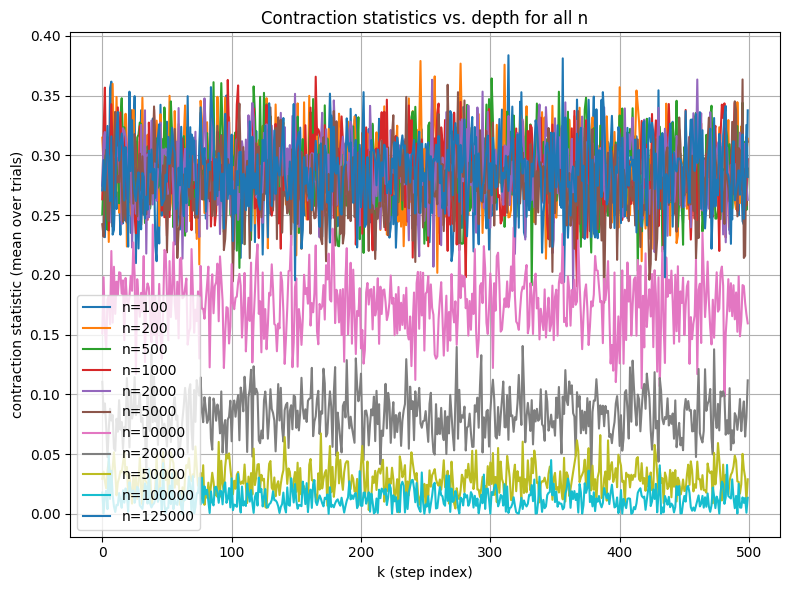

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

BASE = "saved_trees_trials/statistics/contraction"

# Gather all n
ns = []
vals = []   # will hold aggregated values (e.g., mean across trials)

for fname in os.listdir(BASE):
    if not fname.startswith("n=") or not fname.endswith(".npy"):
        continue

    # extract n
    n = int(fname.split("=")[1].split(".")[0])
    ns.append(n)

    # load array: shape (num_trials, K)
    arr = np.load(os.path.join(BASE, fname))

    # choose a statistic:
    # Option A: mean across trials (shape: (K,))
    stat = arr.mean(axis=0)

    # store it
    vals.append(stat)

# Sort by n so plot is ordered
ns, vals = zip(*sorted(zip(ns, vals)))

# Plot all n curves on 1 figure
plt.figure(figsize=(8,6))

for n, v in zip(ns, vals):
    plt.plot(v, label=f"n={n}")

plt.xlabel("k (step index)")
plt.ylabel("contraction statistic (mean over trials)")
plt.title("Contraction statistics vs. depth for all n")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


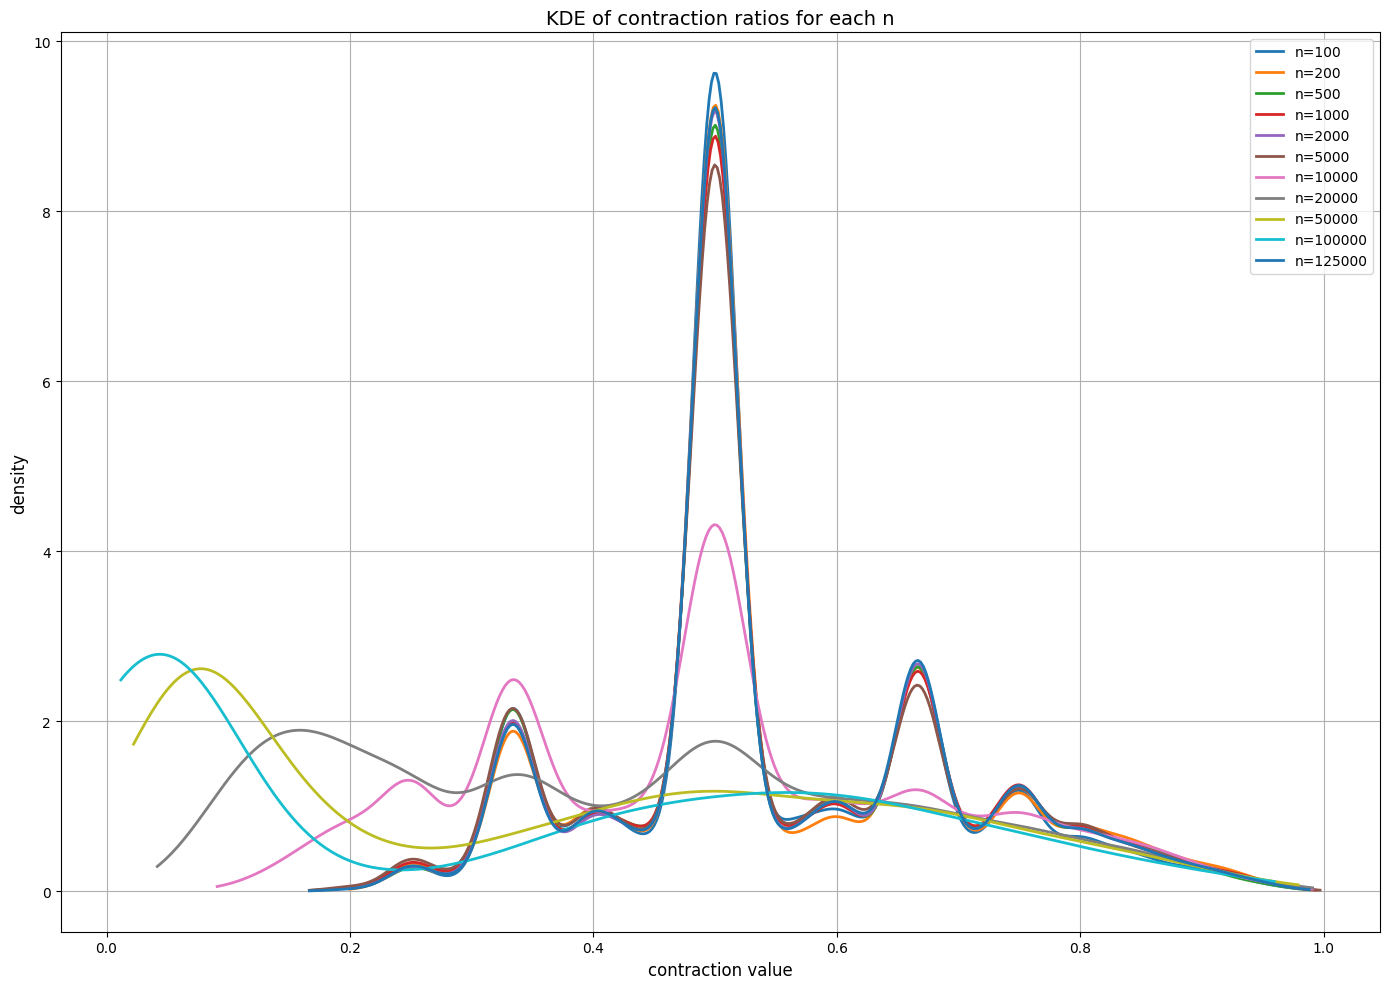

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

BASE = "saved_trees_trials/statistics/contraction"


ns = []
data = []  # flattened data for each n

for fname in os.listdir(BASE):
    if not fname.startswith("n=") or not fname.endswith(".npy"):
        continue

    # extract n value
    n = int(fname.split("=")[1].split(".")[0])
    ns.append(n)

    # load (num_trials, K)
    arr = np.load(os.path.join(BASE, fname))

    # flatten over trials × steps → a single 1D distribution
    flat = arr.flatten()

    # ---- REMOVE 0.0 values ----
    flat = flat[flat != 0.0]
    
    data.append(flat)

# sort by n so lines appear in order
ns, data = zip(*sorted(zip(ns, data)))

# ---------- KDE PLOT ----------
plt.figure(figsize=(14,10))

for n, arr in zip(ns, data):
    kde = gaussian_kde(arr)
    xs = np.linspace(arr.min(), arr.max(), 400)
    plt.plot(xs, kde(xs), label=f"n={n}")

plt.title("KDE of contraction ratios for each n")
plt.xlabel("contraction value")
plt.ylabel("density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import os
import numpy as np

BASE = "saved_trees_trials/statistics/contraction"

for fname in sorted(os.listdir(BASE)):
    if not fname.startswith("n=") or not fname.endswith(".npy"):
        continue

    # extract n
    n = int(fname.split("=")[1].split(".")[0])

    # load file
    arr = np.load(os.path.join(BASE, fname))

    # arr shape: (num_trials, K)
    max_val = arr.max()

    print(f"n={n}: max={max_val}")


n=100: max=0.9800000190734863
n=1000: max=0.9937402009963989
n=10000: max=0.9908257126808167
n=100000: max=0.9595375657081604
n=125000: max=0.9882352948188782
n=200: max=0.978723406791687
n=2000: max=0.9913793206214905
n=20000: max=0.9909909963607788
n=500: max=0.9882352948188782
n=5000: max=0.9971346855163574
n=50000: max=0.9792746305465698
